In [1]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
cd

C:\Users\37789


In [3]:
df = pd.read_csv('sampled_data.csv')
# df=df.sample(n=1000)

In [4]:
df.select_dtypes(include = ["object"]).columns

Index(['Airline', 'Source', 'Destination', 'Class', 'Date', 'Departure_24hr',
       'Arrival_24hr'],
      dtype='object')

In [5]:
class_mapping = {
    'First Class': 4,
    'Business Class': 3,
    'Premium Economy': 2,
    'Economy Class': 1,
    'Other': 0
}
df['Class'] = df['Class'].map(class_mapping)
print(df.head())

             Airline                Source                Destination  \
0  Multiple Airlines  Toronto Pearson Intl  Mexico City Benito Juarez   
1  Multiple Airlines  Toronto Pearson Intl             Bengaluru Intl   
2    United Airlines  Toronto Pearson Intl  Mexico City Benito Juarez   
3  Multiple Airlines  Toronto Pearson Intl  Colombo Bandaranaike Intl   
4  Multiple Airlines             Ahmedabad       Toronto Pearson Intl   

   Number of Stops  Class        Date  Total_Stopover_Time  price in CAD  \
0                2      1  2024-07-30                  161         511.0   
1                2      0  2024-07-19                  197        2694.0   
2                2      1  2024-06-07                  340         665.0   
3                1      1  2024-08-07                  415        2435.0   
4                2      1  2024-07-19                  415        6325.0   

   days_left Departure_24hr Arrival_24hr  Arrival_Day_Offset  
0         39          11:35        19:05 

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df.drop(columns=['Date'], inplace=True)

In [7]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_array = encoder.fit_transform(df[['Source', 'Destination']])
feature_names = encoder.get_feature_names_out(['Source', 'Destination'])
encoded_df = pd.DataFrame(encoded_array, columns=feature_names)
df = df.join(encoded_df)
df.drop(['Source', 'Destination'], axis=1, inplace=True)

In [8]:
def time_to_minutes(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes
df['Departure_minutes'] = df['Departure_24hr'].apply(time_to_minutes)
df['Arrival_minutes'] = df['Arrival_24hr'].apply(time_to_minutes)
df.drop(['Departure_24hr', 'Arrival_24hr'], axis=1, inplace=True)

In [9]:
top_20_airlines = df['Airline'].value_counts().nlargest(20).index

for airline in top_20_airlines:
    df[f'Airline_{airline}'] = (df['Airline'] == airline).astype(int)
df['Airline_Other'] = ~df['Airline'].isin(top_20_airlines).astype(int)
df.drop(columns=['Airline'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 57 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Number of Stops                               10000 non-null  int64  
 1   Class                                         10000 non-null  int64  
 2   Total_Stopover_Time                           10000 non-null  int64  
 3   price in CAD                                  10000 non-null  float64
 4   days_left                                     10000 non-null  int64  
 5   Arrival_Day_Offset                            10000 non-null  int64  
 6   Year                                          10000 non-null  int32  
 7   Month                                         10000 non-null  int32  
 8   Day                                           10000 non-null  int32  
 9   Source_Bengaluru Intl                         10000 non-null  

In [11]:
# Perform a train-test split
X = df.drop('price in CAD', axis=1)
y = df['price in CAD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Define the parameter distribution for RandomForest
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 3)
}

# Instantiate the randomized search with fewer iterations
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=20,  # Reduced number of iterations
                                   cv=3, n_jobs=-1, verbose=2,
                                   random_state=42)

# Fit the randomized search to the subset of the data
random_search.fit(X_train_scaled, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Predict and evaluate the model
y_pred_best = best_model.predict(X_test_scaled)
best_mae = mean_absolute_error(y_test, y_pred_best)
print(f'Best MAE: {best_mae}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best MAE: 625.3194569284648


In [14]:
# Set a new performance threshold based on the improved model
performance_threshold = best_mae + 10  # Allowing a small margin
print(f'New Performance Threshold (MAE): {performance_threshold}')

New Performance Threshold (MAE): 635.3194569284648


In [15]:
# Function to generate adversarial examples
def generate_adversarial_examples(X, epsilon=0.1):
    X_adv = X + epsilon * np.sign(np.random.randn(*X.shape))
    return X_adv

# Function to add Gaussian noise
def add_gaussian_noise(data, mean=0, std=1):
    noise = np.random.normal(mean, std, data.shape)
    return data + noise

# Function to add uniform noise
def add_uniform_noise(data, low=-0.1, high=0.1):
    noise = np.random.uniform(low, high, data.shape)
    return data + noise

In [16]:
# Data preparation (assuming X_train, y_train, X_test, y_test, and scaler are already defined)
X_train_adv = generate_adversarial_examples(X_train.values, epsilon=1000)
X_train_combined_adv = np.vstack((X_train.values, X_train_adv))
y_train_combined_adv = np.hstack((y_train.values, y_train.values))

In [17]:
X_train_gaussian = add_gaussian_noise(X_train.values)
X_train_combined_gaussian = np.vstack((X_train.values, X_train_gaussian))
y_train_combined_gaussian = np.hstack((y_train.values, y_train.values))

In [18]:
# Placeholder for data augmentation - replace with actual augmentation technique
X_train_aug = add_gaussian_noise(X_train.values) # Example of augmentation
X_train_combined_aug = np.vstack((X_train.values, X_train_aug))
y_train_combined_aug = np.hstack((y_train.values, y_train.values))

In [19]:
# Scale the combined data
X_train_combined_adv_scaled = scaler.transform(X_train_combined_adv)
X_train_combined_gaussian_scaled = scaler.transform(X_train_combined_gaussian)
X_train_combined_aug_scaled = scaler.transform(X_train_combined_aug)

In [20]:
# Train additional models
# Gaussian noise model
best_model_gaussian = RandomForestRegressor(n_estimators=100, random_state=42)
best_model_gaussian.fit(X_train_combined_gaussian_scaled, y_train_combined_gaussian)

RandomForestRegressor(random_state=42)

In [21]:
# Adversarial training model
best_model_adv = RandomForestRegressor(n_estimators=100, random_state=42)
best_model_adv.fit(X_train_combined_adv_scaled, y_train_combined_adv)

RandomForestRegressor(random_state=42)

In [22]:
# Ridge regularization model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [23]:
# Data augmentation model
best_model_aug = RandomForestRegressor(n_estimators=100, random_state=42)
best_model_aug.fit(X_train_combined_aug_scaled, y_train_combined_aug)

RandomForestRegressor(random_state=42)

In [24]:
# Generate predictions
y_pred_gaussian = best_model_gaussian.predict(X_test_scaled)
y_pred_adv = best_model_adv.predict(X_test_scaled)
y_pred_ridge = ridge_model.predict(X_test_scaled)
y_pred_aug = best_model_aug.predict(X_test_scaled)

In [25]:
# Add uniform noise and predict
X_test_uniform = add_uniform_noise(X_test.values, low=-0.1, high=0.1)
X_test_uniform_scaled = scaler.transform(X_test_uniform)
y_pred_uniform = best_model_aug.predict(X_test_uniform_scaled)
uniform_mae = mean_absolute_error(y_test, y_pred_uniform)
print(f'MAE with Uniform noise: {uniform_mae}')

MAE with Uniform noise: 770.7076044285715


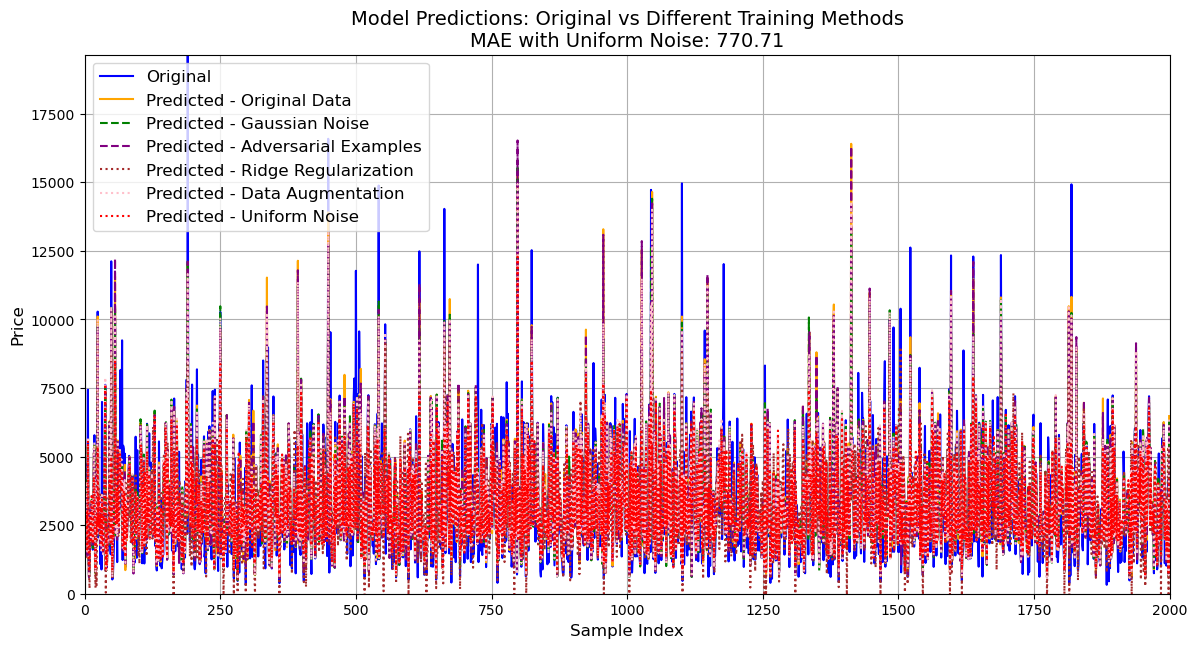

In [26]:
# Plot results with improvements
plt.figure(figsize=(14, 7))

# Original Data
plt.plot(y_test.values, label='Original', color='blue', linewidth=1.5)

# Predicted - Original Data
plt.plot(y_pred_best, label='Predicted - Original Data', color='orange', linewidth=1.5)

# Predicted - Gaussian Noise
plt.plot(y_pred_gaussian, label='Predicted - Gaussian Noise', linestyle='dashed', color='green', linewidth=1.5)

# Predicted - Adversarial Examples
plt.plot(y_pred_adv, label='Predicted - Adversarial Examples', linestyle='dashed', color='purple', linewidth=1.5)

# Predicted - Ridge Regularization
plt.plot(y_pred_ridge, label='Predicted - Ridge Regularization', linestyle='dotted', color='brown', linewidth=1.5)

# Predicted - Data Augmentation
plt.plot(y_pred_aug, label='Predicted - Data Augmentation', linestyle='dotted', color='pink', linewidth=1.5)

# Predicted - Uniform Noise
plt.plot(y_pred_uniform, label='Predicted - Uniform Noise', linestyle='dotted', color='red', linewidth=1.5)

# Add gridlines, title, labels, and legend
plt.grid(True)
plt.title('Model Predictions: Original vs Different Training Methods\n'
          f'MAE with Uniform Noise: {uniform_mae:.2f}', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=12)

# Set x-axis and y-axis limits
plt.xlim(0, len(y_test.values))
plt.ylim(0, np.max(y_test.values))

plt.show()

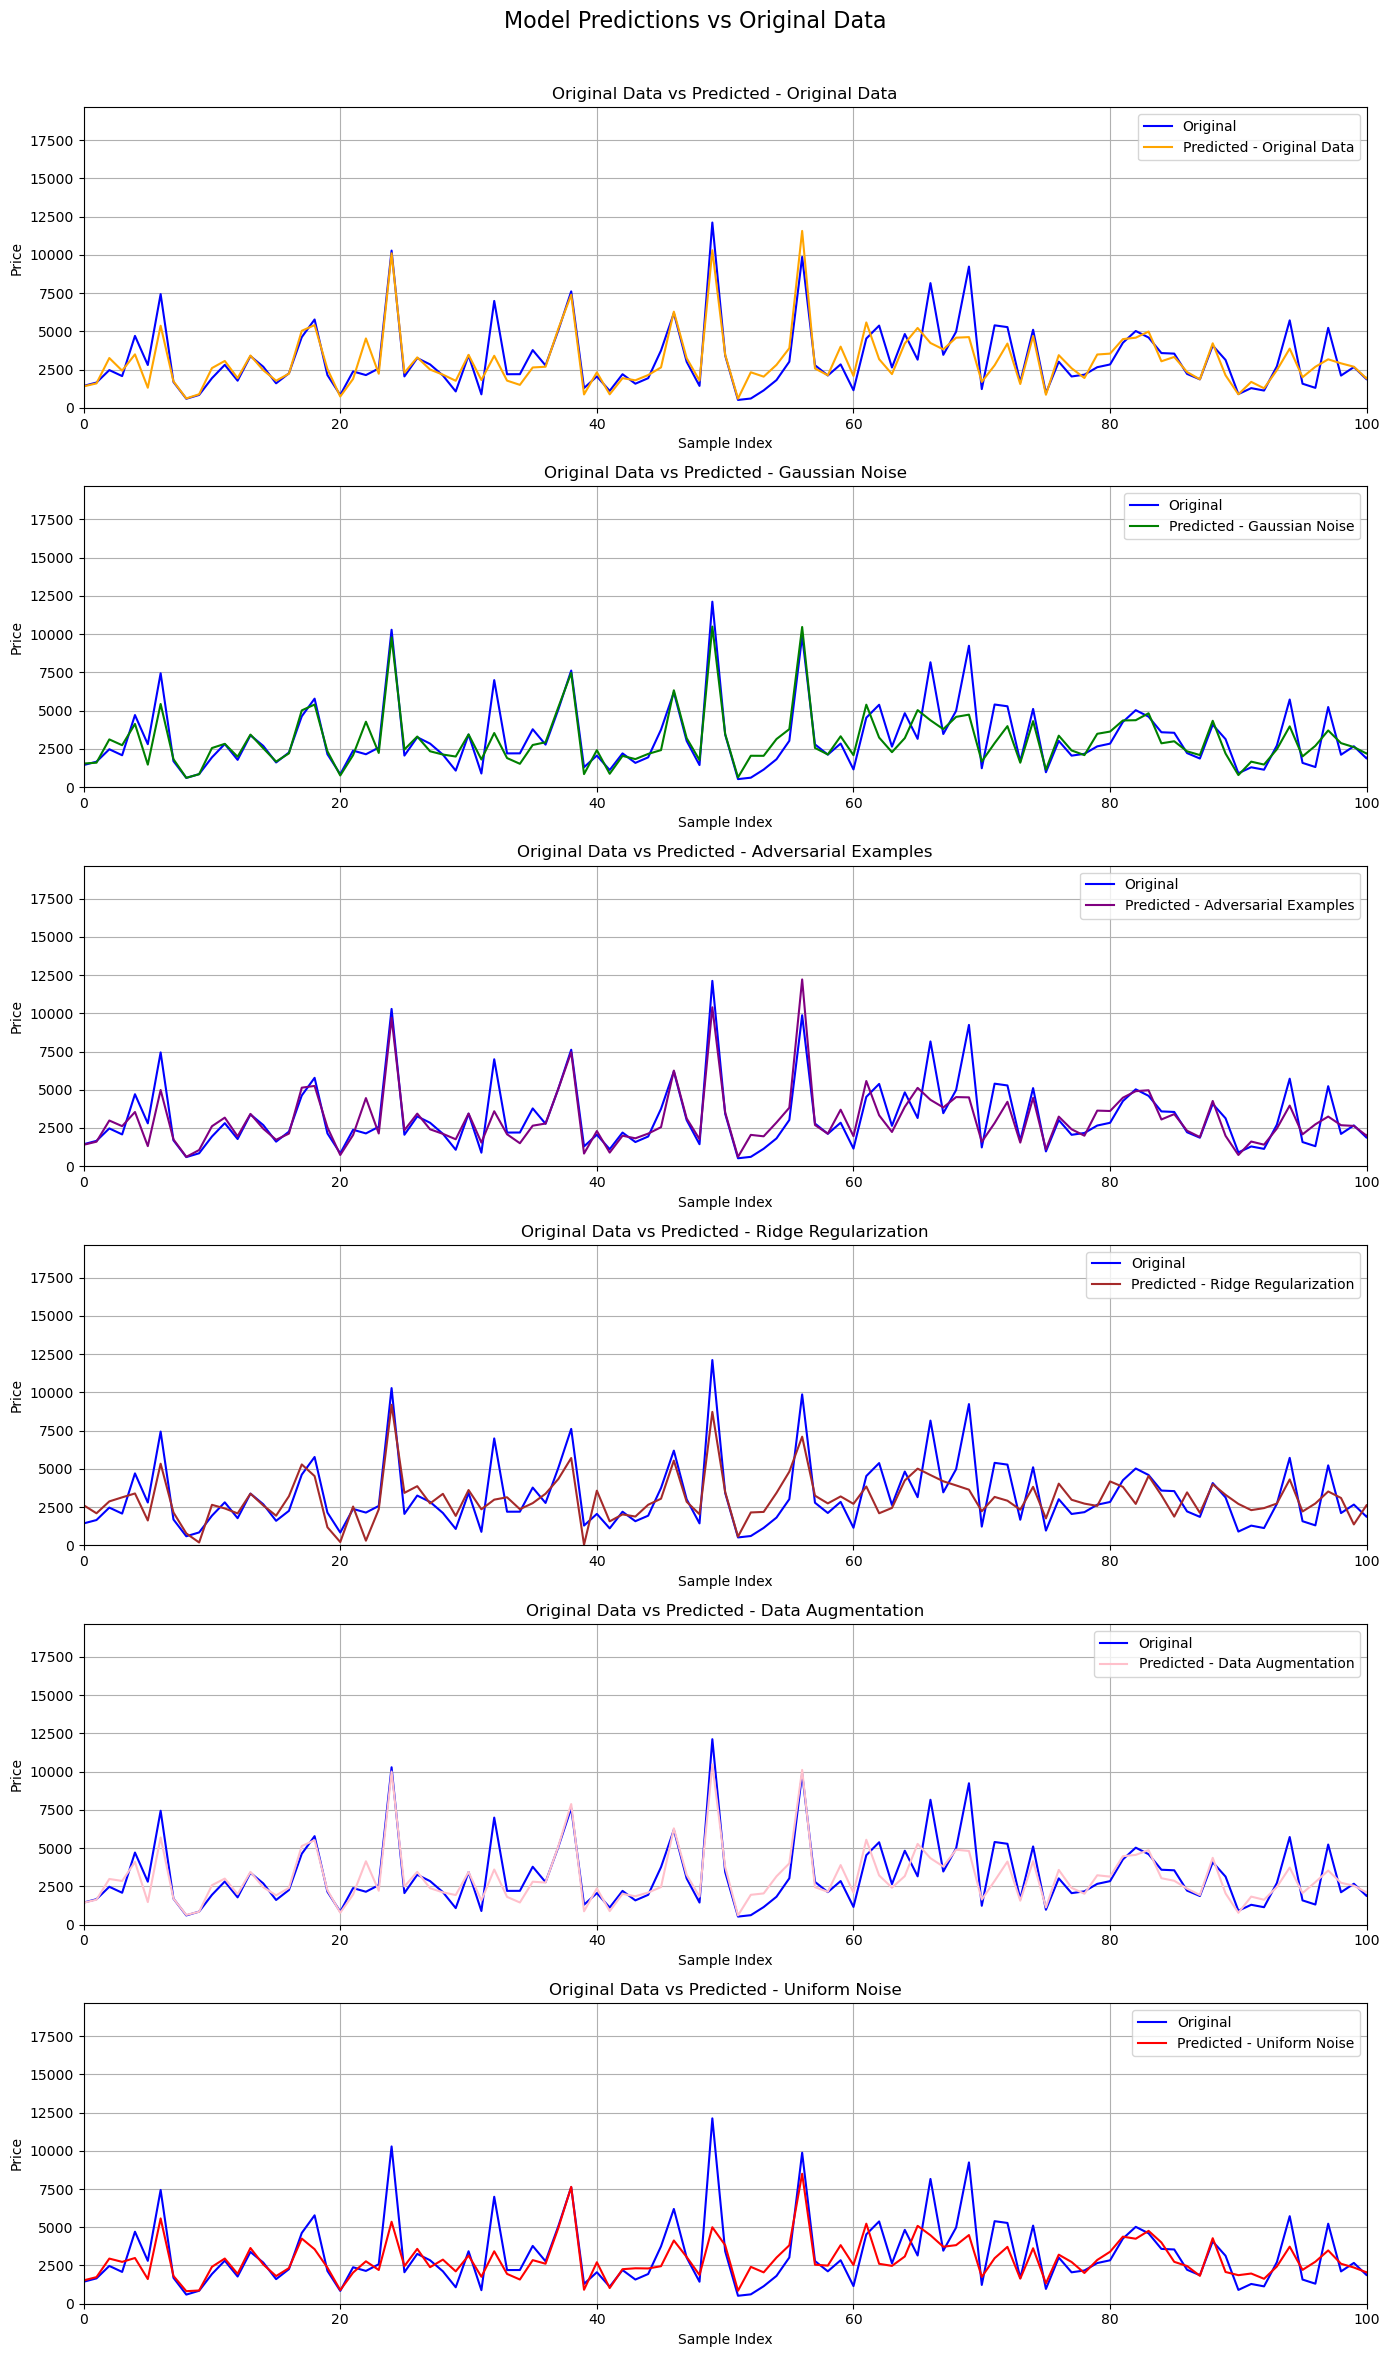

In [27]:
# Original Data
original_data = y_test.values

# Define a list of models and their corresponding predictions and labels
models = [
    (y_pred_best, 'Predicted - Original Data', 'orange'),
    (y_pred_gaussian, 'Predicted - Gaussian Noise', 'green'),
    (y_pred_adv, 'Predicted - Adversarial Examples', 'purple'),
    (y_pred_ridge, 'Predicted - Ridge Regularization', 'brown'),
    (y_pred_aug, 'Predicted - Data Augmentation', 'pink'),
    (y_pred_uniform, 'Predicted - Uniform Noise', 'red')
]

# Plot each model's predictions in a separate subplot
fig, axs = plt.subplots(len(models), 1, figsize=(14, len(models) * 4))
fig.suptitle('Model Predictions vs Original Data', fontsize=16)

# Set the range for zooming in (adjust these values as needed)
sample_start, sample_end = 0, 100  # Range of samples to zoom in on
price_min, price_max = 0, np.max(y_test.values)  # Range of prices to zoom in on

for i, (y_pred, label, color) in enumerate(models):
    axs[i].plot(original_data, label='Original', color='blue', linewidth=1.5)
    axs[i].plot(y_pred, label=label, color=color, linewidth=1.5)
    axs[i].grid(True)
    axs[i].set_title(f'Original Data vs {label}')
    axs[i].set_xlabel('Sample Index')
    axs[i].set_ylabel('Price')
    axs[i].legend()
    
    # Set limits to zoom in
    axs[i].set_xlim(sample_start, sample_end)
    axs[i].set_ylim(price_min, price_max)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit the main title
plt.show()


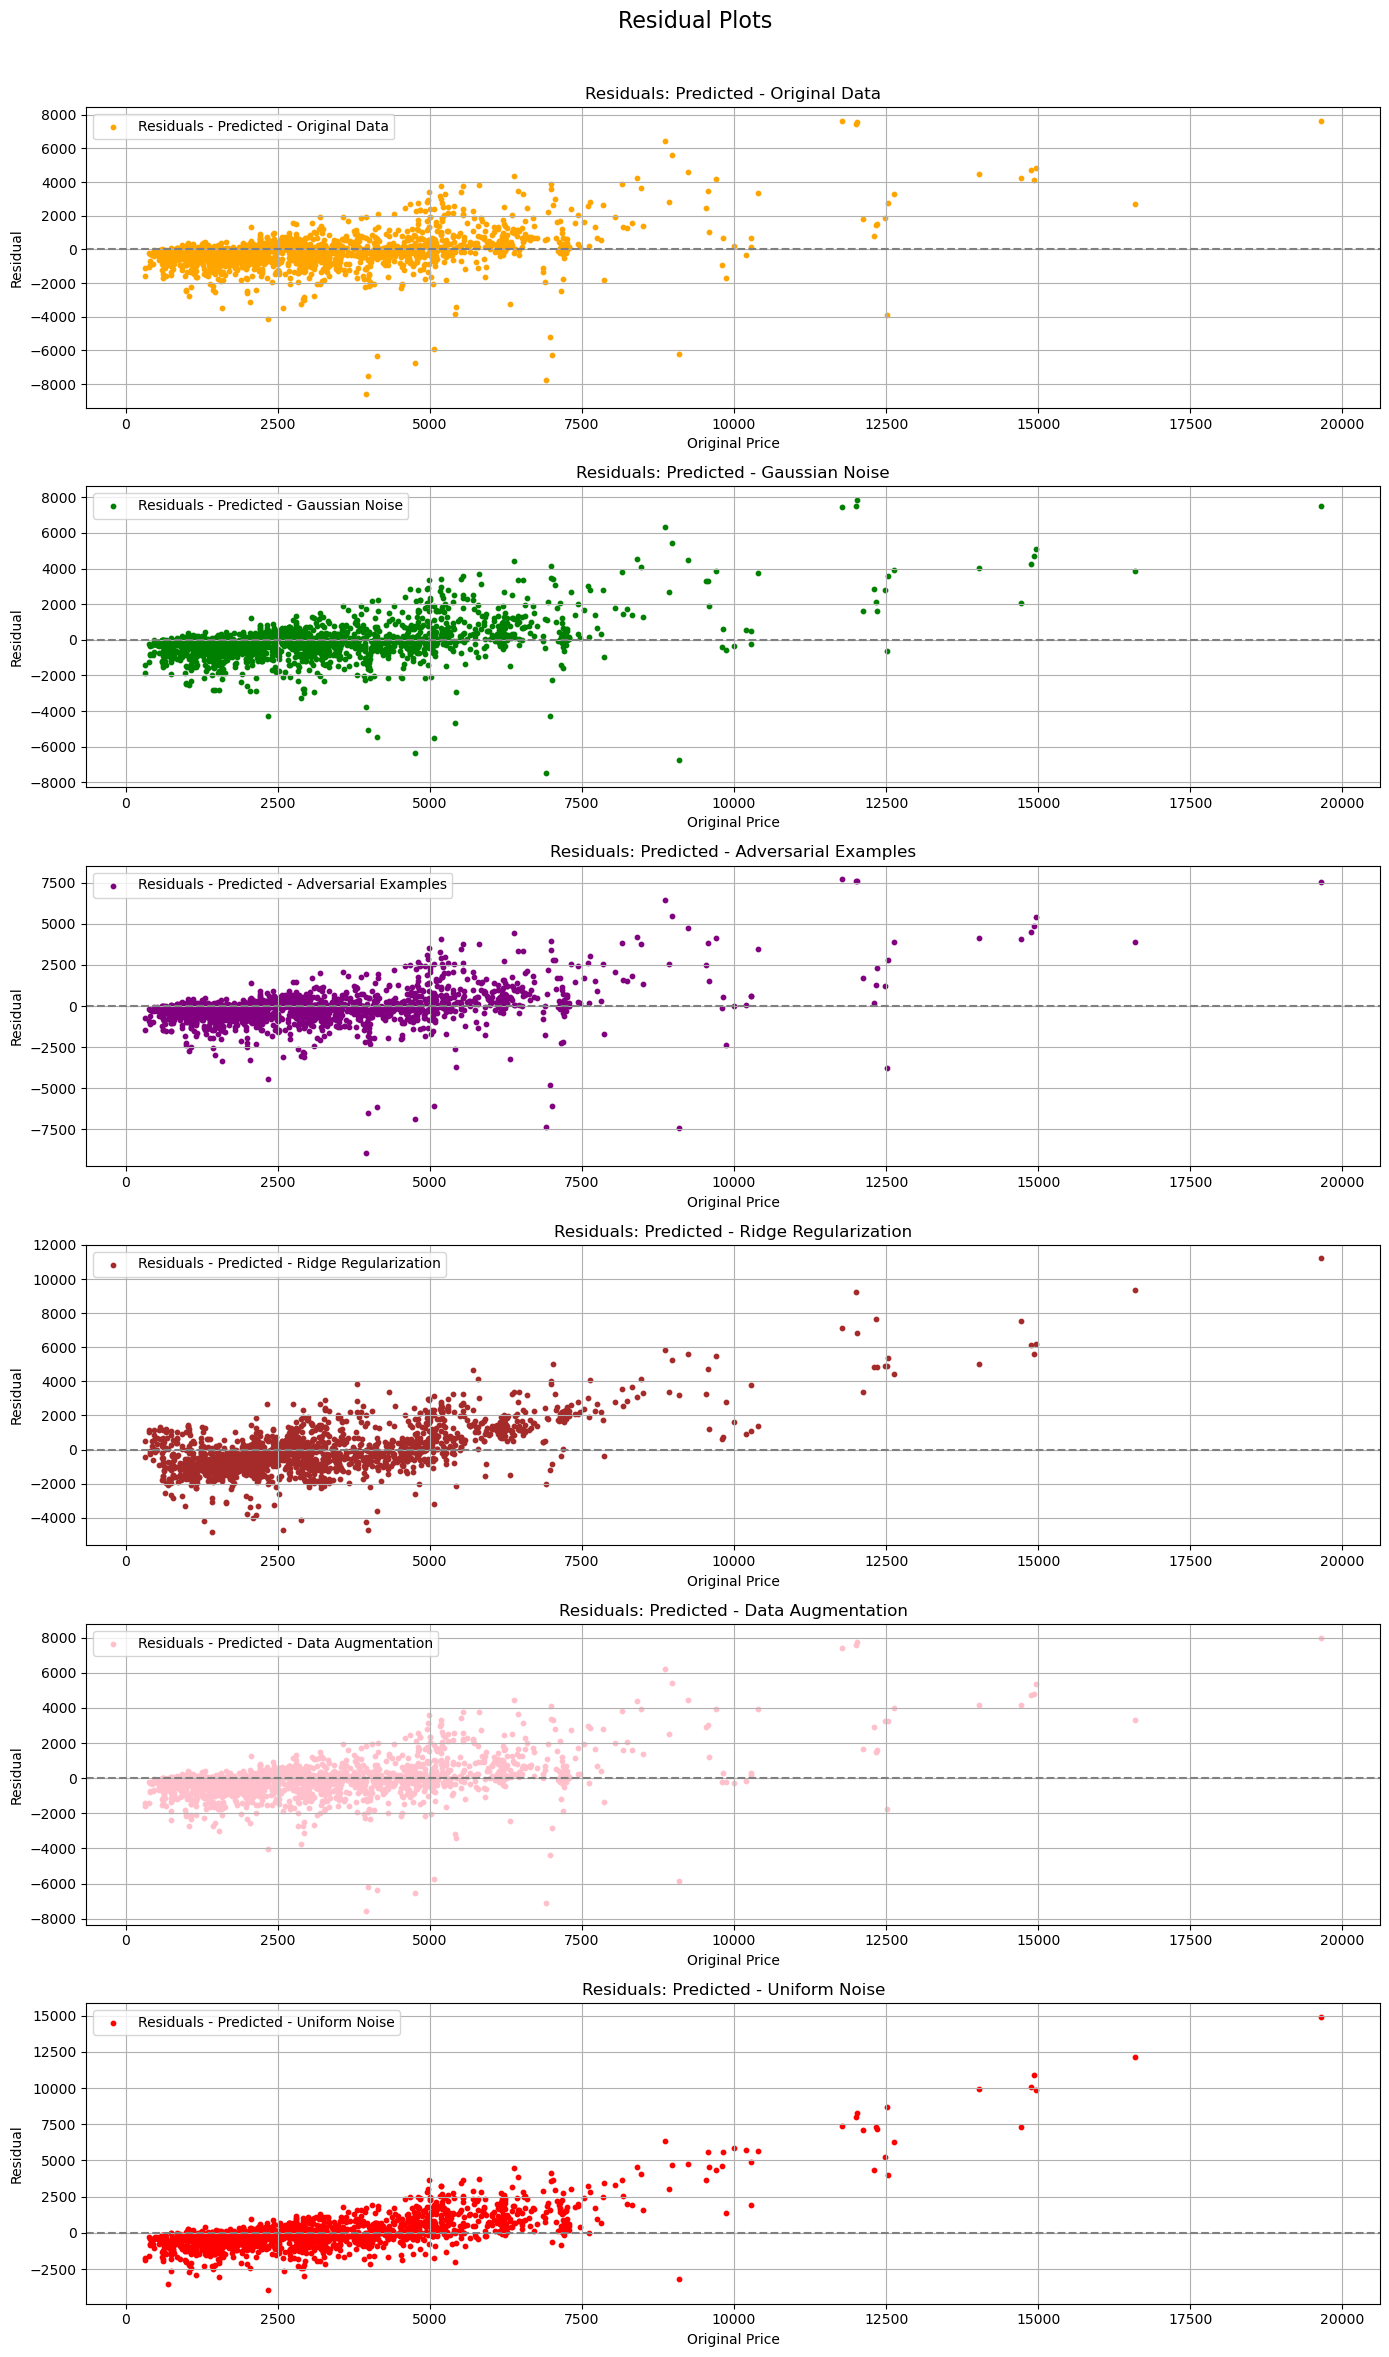

In [28]:
# Residual plots for each model
fig, axs = plt.subplots(len(models), 1, figsize=(14, len(models) * 4))
fig.suptitle('Residual Plots', fontsize=16)

for i, (y_pred, label, color) in enumerate(models):
    residuals = original_data - y_pred
    axs[i].scatter(original_data, residuals, label=f'Residuals - {label}', color=color, s=10)
    axs[i].axhline(y=0, color='grey', linestyle='--')
    axs[i].grid(True)
    axs[i].set_title(f'Residuals: {label}')
    axs[i].set_xlabel('Original Price')
    axs[i].set_ylabel('Residual')
    axs[i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Original Test MSE: 1183620.5848164945
Shifted Test MSE: 6526659.789032701


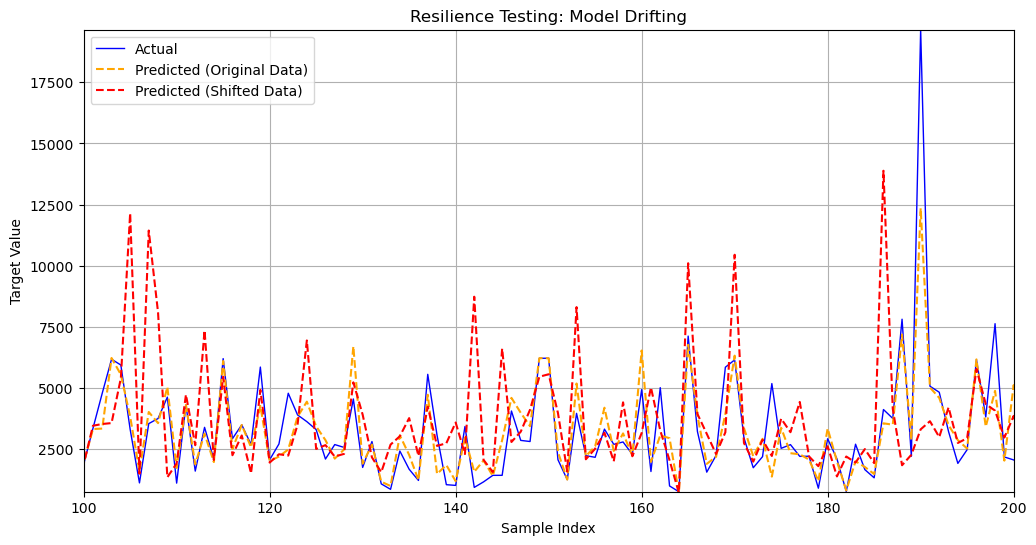

In [35]:
# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Original model predictions
y_pred_original = model.predict(X_test)
mse_original = mean_squared_error(y_test, y_pred_original)
print(f'Original Test MSE: {mse_original}')

# Simulate concept drift by adding Gaussian noise to the test data
X_test_shifted = X_test + np.random.normal(0, 0.5, X_test.shape)

# Model predictions on the drifted test set
y_pred_shifted = model.predict(X_test_shifted)
mse_shifted = mean_squared_error(y_test, y_pred_shifted)
print(f'Shifted Test MSE: {mse_shifted}')

# Visualization of original vs drifted predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue', linewidth=1)
plt.plot(y_pred_original, label='Predicted (Original Data)', color='orange', linestyle='--')
plt.plot(y_pred_shifted, label='Predicted (Shifted Data)', color='red', linestyle='--')
plt.title('Resilience Testing: Model Drifting')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)

# Zoom in on a specific range (e.g., samples from 100 to 200)
plt.xlim(100, 200)  # Adjust these values as needed
plt.ylim(min(y_test.values[100:200]) - 1, max(y_test.values[100:200]) + 1)  # Adjust these limits for y-axis

plt.show()


Training Time with Full Data: 10.93 seconds
Test MSE with Full Data: 1183620.5848164945
Training Time with Limited Data: 1.21 seconds
Test MSE with Limited Data: 1743460.5295266055


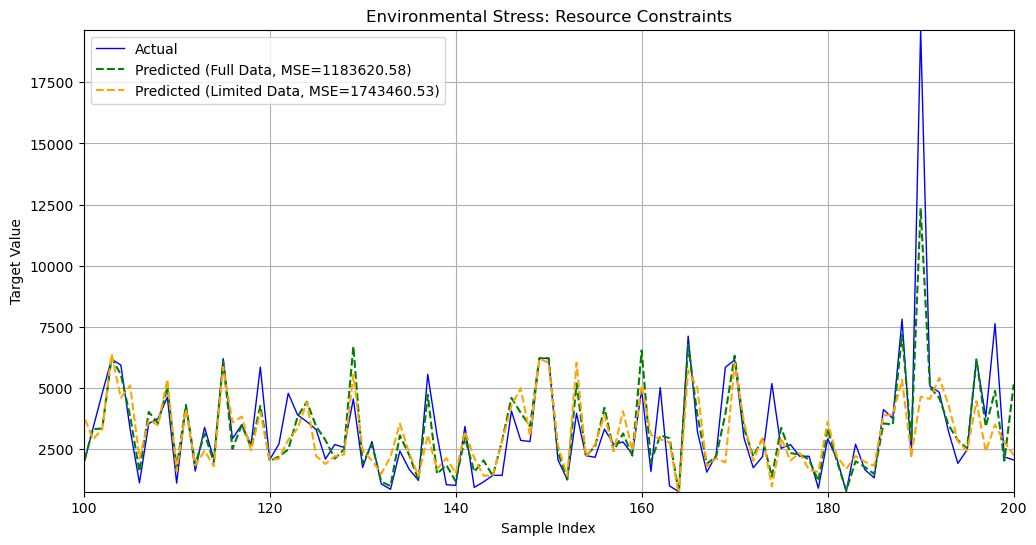

In [36]:
# Full data training
model_full = RandomForestRegressor(random_state=42)
start_time = time.time()
model_full.fit(X_train, y_train)
train_time_full = time.time() - start_time
print(f"Training Time with Full Data: {train_time_full:.2f} seconds")

# Predictions and MSE on full data
y_pred_full = model_full.predict(X_test)
mse_full = mean_squared_error(y_test, y_pred_full)
print(f'Test MSE with Full Data: {mse_full}')

# Limited data training (10% of the data)
X_train_limited = X_train.sample(frac=0.1, random_state=42)
y_train_limited = y_train.loc[X_train_limited.index]

model_limited = RandomForestRegressor(random_state=42)
start_time = time.time()
model_limited.fit(X_train_limited, y_train_limited)
train_time_limited = time.time() - start_time
print(f"Training Time with Limited Data: {train_time_limited:.2f} seconds")

# Predictions and MSE on limited data
y_pred_limited = model_limited.predict(X_test)
mse_limited = mean_squared_error(y_test, y_pred_limited)
print(f'Test MSE with Limited Data: {mse_limited}')

# Visualization of full vs limited data performance
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue', linewidth=1)
plt.plot(y_pred_full, label=f'Predicted (Full Data, MSE={mse_full:.2f})', color='green', linestyle='--')
plt.plot(y_pred_limited, label=f'Predicted (Limited Data, MSE={mse_limited:.2f})', color='orange', linestyle='--')
plt.title('Environmental Stress: Resource Constraints')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)

# Zoom in on a specific range (e.g., samples from 100 to 200)
plt.xlim(100, 200)  # Adjust these values as needed
plt.ylim(min(y_test.values[100:200]) - 1, max(y_test.values[100:200]) + 1)  # Adjust these limits for y-axis

plt.show()